# **Gold Price Prediction**
 This is simple machine learning linear regression model that takes information from the past Gold ETF (GLD) prices and returns a Gold price prediction the next day.

 *GLD is the largest ETF to invest directly in physical gold.*

In [25]:
from sklearn.linear_model import LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.impute import SimpleImputer
plt.style.use('seaborn-darkgrid')
import yfinance as yf

<ipython-input-25-7bc7782d3d90>:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


In [27]:
# Read data
Df = yf.download('GLD', '2008-01-01', '2020-6-22', auto_adjust=True)

# Only keep close columns
Df = Df[['Close']]

# Drop rows with missing values
Df = Df.dropna()

# Impute missing values with mean
imputer = SimpleImputer(strategy='mean')
forecast_features_imputed = imputer.fit_transform(forecast_features)

[*********************100%%**********************]  1 of 1 completed


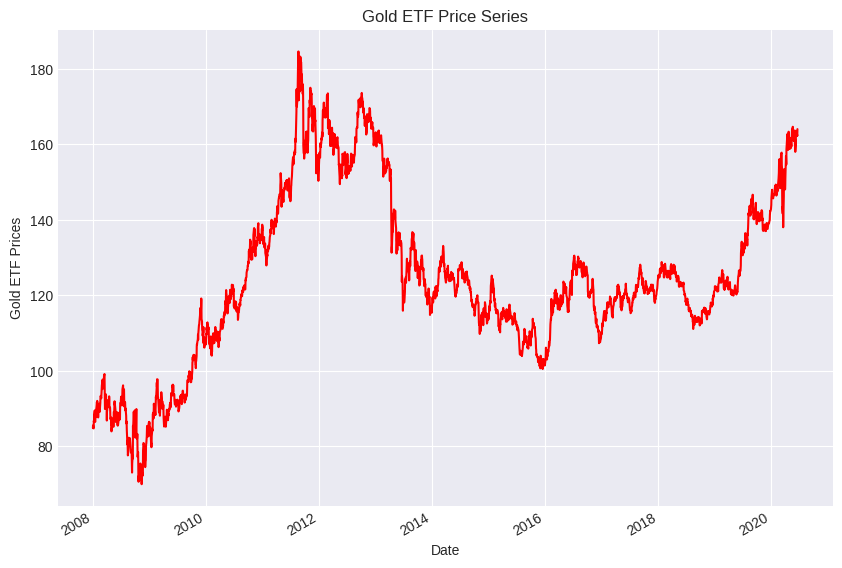

In [26]:
# Plot the closing price of GLD
Df.Close.plot(figsize=(10, 7),color='r')
plt.ylabel("Gold ETF Prices")
plt.title("Gold ETF Price Series")
plt.show()

# Adding Technical Indicators

In [15]:
# RSI (Relative Strength Index)
def calculate_rsi(data, window=14):
    delta = data['Close'].diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=window).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=window).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

Df['RSI'] = calculate_rsi(Df)

# MACD (Moving Average Convergence Divergence)
def calculate_macd(data):
    short_window = 12
    long_window = 26
    data['short_ema'] = data['Close'].ewm(span=short_window, min_periods=1, adjust=False).mean()
    data['long_ema'] = data['Close'].ewm(span=long_window, min_periods=1, adjust=False).mean()
    data['MACD'] = data['short_ema'] - data['long_ema']
    data['Signal_Line'] = data['MACD'].ewm(span=9, min_periods=1, adjust=False).mean()
    return data

Df = calculate_macd(Df)

# Bollinger Bands
def calculate_bollinger_bands(data, window=20):
    data['MA'] = data['Close'].rolling(window=window).mean()
    data['BB_up'] = data['MA'] + 2 * data['Close'].rolling(window=window).std()
    data['BB_down'] = data['MA'] - 2 * data['Close'].rolling(window=window).std()
    return data

Df = calculate_bollinger_bands(Df)

# Stochastic Oscillator
def calculate_stochastic_oscillator(data, window=14):
    data['14 High'] = data['Close'].rolling(window=window).max()
    data['14 Low'] = data['Close'].rolling(window=window).min()
    data['%K'] = ((data['Close'] - data['14 Low']) / (data['14 High'] - data['14 Low'])) * 100
    data['%D'] = data['%K'].rolling(window=3).mean()
    return data

Df = calculate_stochastic_oscillator(Df)

In [16]:

# Add RSI, MACD, Bollinger Bands, and Stochastic Oscillator to X
X = Df[['RSI', 'MACD', 'Signal_Line', 'BB_up', 'BB_down', '%K', '%D']]

# Define dependent variable
y = Df['Close']

# Train and Test split
# Split the data into train and test dataset
t = .8
t = int(t * len(Df))

# Train dataset
X_train = X[:t]
y_train = y[:t]

# Test dataset
X_test = X[t:]
y_test = y[t:]

# Drop rows with missing values
X_train.dropna(inplace=True)
y_train = y_train[X_train.index]  # Keep only corresponding y values


# Create a linear regression model
linear = LinearRegression().fit(X_train, y_train)

<ipython-input-16-81e1bb07f87a>:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.dropna(inplace=True)


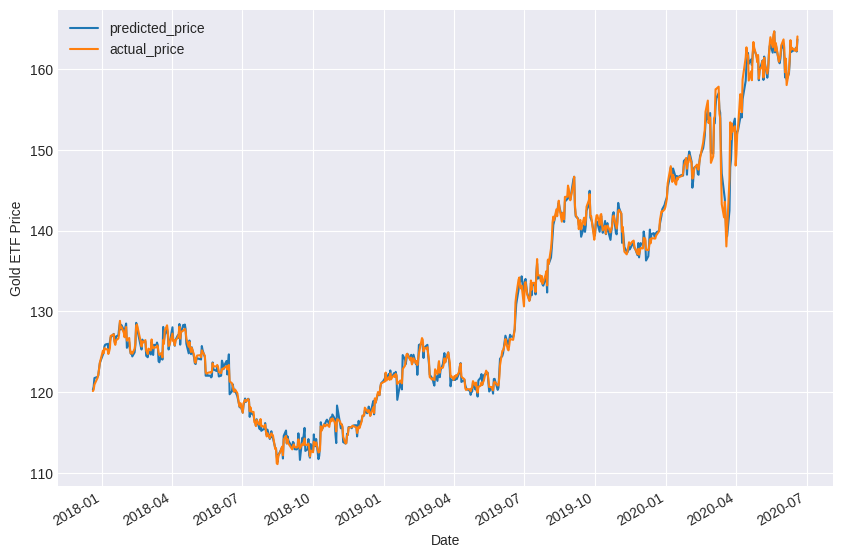

In [17]:
# Predicting the Gold ETF prices
predicted_price = linear.predict(X_test)
predicted_price = pd.DataFrame(predicted_price, index=y_test.index, columns=['price'])
predicted_price.plot(figsize=(10, 7))
y_test.plot()
plt.legend(['predicted_price', 'actual_price'])
plt.ylabel("Gold ETF Price")
plt.show()

In [18]:
# Calculate R square
r2_score = linear.score(X_test, y_test) * 100
print("R squared value:", r2_score)

# Calculate Mean Absolute Error
from sklearn.metrics import mean_absolute_error
mae = mean_absolute_error(y_test, predicted_price)
print("Mean Absolute Error:", mae)

# Calculate Mean Squared Error
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test, predicted_price)
print("Mean Squared Error:", mse)

# Calculate Root Mean Squared Error
rmse = np.sqrt(mse)
print("Root Mean Squared Error:", rmse)

# Drop NaN values
gold.dropna(inplace=True)

# Calculate MAPE and MPE
mape = np.mean(np.abs((gold['price'] - gold['predicted_price_next_day']) / gold['price'])) * 100
mpe = np.mean((gold['price'] - gold['predicted_price_next_day']) / gold['price']) * 100

print("Mean Absolute Percentage Error:", mape)
print("Mean Percentage Error:", mpe)


R squared value: 99.75073812751923
Mean Absolute Error: 0.476589007882501
Mean Squared Error: 0.5013302868443793
Root Mean Squared Error: 0.7080468111956859
Mean Absolute Percentage Error: 0.3580001495584564
Mean Percentage Error: 0.0400101237809907


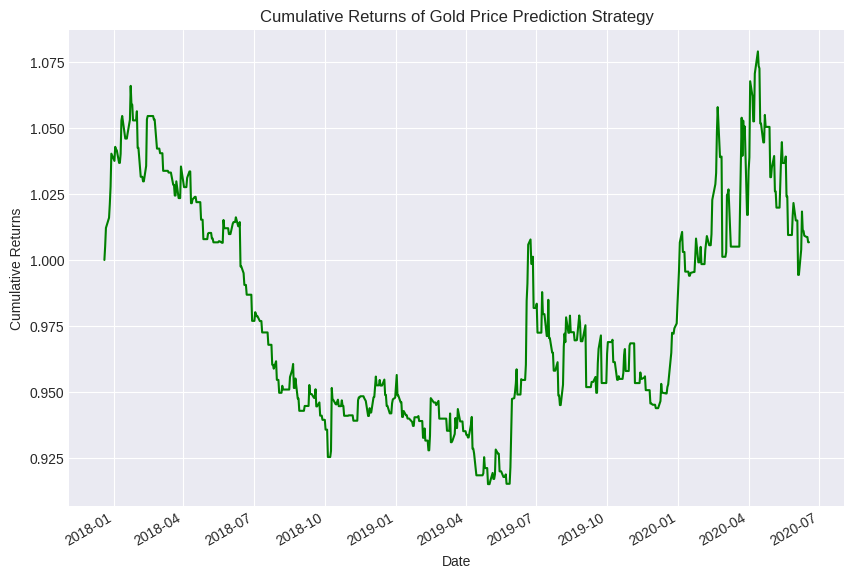

In [19]:
# Visualizing the Cumulative Returns of the Strategy
gold = pd.DataFrame()
gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)
gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day, 1, 0)
gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns'] + 1).cumprod()).plot(figsize=(10, 7), color='g')
plt.ylabel('Cumulative Returns')
plt.title('Cumulative Returns of Gold Price Prediction Strategy')
plt.show()

In [20]:
# Calculate Sharpe Ratio
sharpe = gold['strategy_returns'].mean() / gold['strategy_returns'].std() * np.sqrt(252)
print("Sharpe Ratio:", sharpe)

Sharpe Ratio: 0.07645420606572595


In [22]:
# Forecasting Gold Price
# Get the data
current_date = pd.to_datetime('today').strftime('%Y-%m-%d')
data = yf.download('GLD', '2008-06-01', current_date, auto_adjust=True)

# Calculate Technical Indicators for the forecast data
data['RSI'] = calculate_rsi(data)
data = calculate_macd(data)
data = calculate_bollinger_bands(data)
data = calculate_stochastic_oscillator(data)

# Select the relevant features for prediction
forecast_features = data[['RSI', 'MACD', 'Signal_Line', 'BB_up', 'BB_down', '%K', '%D']]

# Forecast the price
data['predicted_gold_price'] = linear.predict(forecast_features_imputed)
data['signal'] = np.where(data.predicted_gold_price.shift(1) < data.predicted_gold_price, "Buy", "No Position")

# Print the forecast
print("Forecasted Signal and Predicted Gold Price:")
print(data[['signal', 'predicted_gold_price']].tail(1).T)


[*********************100%%**********************]  1 of 1 completed

Forecasted Signal and Predicted Gold Price:
Date                  2024-05-15
signal                       Buy
predicted_gold_price  219.158758



/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


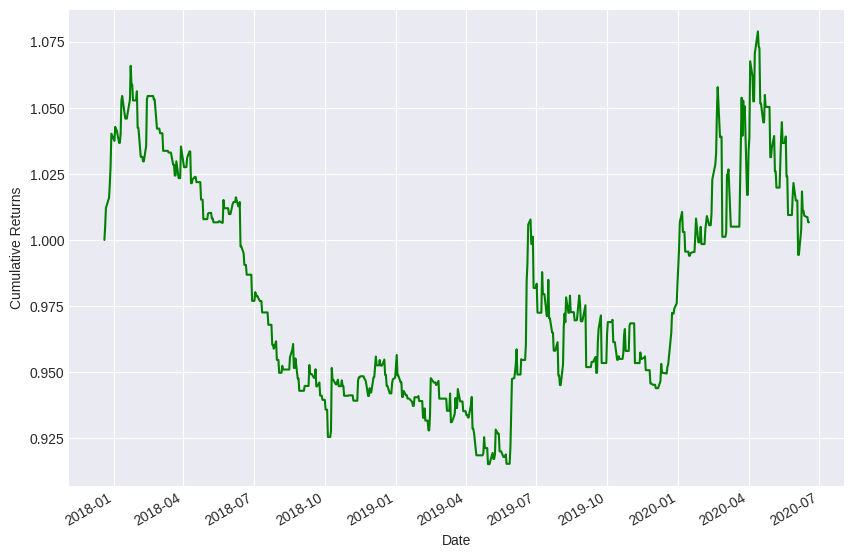

'Sharpe Ratio 0.08'

In [23]:
gold = pd.DataFrame()

gold['price'] = Df[t:]['Close']
gold['predicted_price_next_day'] = predicted_price
gold['actual_price_next_day'] = y_test
gold['gold_returns'] = gold['price'].pct_change().shift(-1)

gold['signal'] = np.where(gold.predicted_price_next_day.shift(1) < gold.predicted_price_next_day,1,0)

gold['strategy_returns'] = gold.signal * gold['gold_returns']
((gold['strategy_returns']+1).cumprod()).plot(figsize=(10,7),color='g')
plt.ylabel('Cumulative Returns')
plt.show()

# Calculate sharpe ratio
sharpe = gold['strategy_returns'].mean()/gold['strategy_returns'].std()*(252**0.5)
'Sharpe Ratio %.2f' % (sharpe)

Refrence: https://blog.quantinsti.com/gold-price-prediction-using-machine-learning-python/